This is the note book for Kaggle Competition - Give Me Some Credit

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
from sklearn import preprocessing,model_selection
import itertools



In [2]:
fileaddress = 'E:\\Kaggle\\Give Me Some Credit\\data'
train_df = pd.read_csv(fileaddress+'\\cs-training.csv')
test_df = pd.read_csv(fileaddress+'\\cs-test.csv')
print (train_df.shape,test_df.shape)

(150000, 12) (101503, 12)


In [3]:
col_names = train_df.columns.values
col_names[0] = 'ID'
train_df.columns = col_names
test_df.columns = col_names
#train_df.head()

In [4]:
test_df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


Check column type

In [5]:
train_df.dtypes

ID                                        int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

check nan values

In [6]:
print (pd.isnull(train_df).sum(axis=0))
print ('TestSet:')
print (pd.isnull(test_df).sum(axis=0))

ID                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64
TestSet:
ID                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
Num

In [44]:
train_df['MonthlyIncome_Null'] = pd.isnull(train_df['MonthlyIncome'])
grouped_df = train_df.groupby('MonthlyIncome_Null')
Dlqin = grouped_df['SeriousDlqin2yrs'].aggregate(np.mean).reset_index()
Dlqin



,MonthlyIncome_Null,SeriousDlqin2yrs
0,False,0.069486
1,True,0.056137


In [45]:
train_df['NoD_Null'] = pd.isnull(train_df['NumberOfDependents'])
grouped_df = train_df.groupby('NoD_Null')
Dlqin = grouped_df['SeriousDlqin2yrs'].aggregate(np.mean).reset_index()
Dlqin

,NoD_Null,SeriousDlqin2yrs
0,False,0.067410
1,True,0.045617


Remove rows where NumberofDependent is nan

In [4]:
print(train_df.shape,type(train_df))
train_df.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
train_df.reset_index()
print(train_df.shape)
pd.isnull(train_df).sum(axis=0)

(150000, 12) <class 'pandas.core.frame.DataFrame'>
(146076, 12)


ID                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           25807
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                          0
dtype: int64

Boxplot to check if outliers exist for numerical columns

New Feature:

In [5]:
#print(set(train_df['NumberOfDependents']))
#print(set(train_df['NumberOfDependents']+1))

train_df['IncomePerPerson'] = train_df['MonthlyIncome']/(train_df['NumberOfDependents']+1)
test_df['IncomePerPerson'] = test_df['MonthlyIncome']/(test_df['NumberOfDependents']+1)
train_df['NumOfPastDue'] = train_df['NumberOfTimes90DaysLate']+train_df['NumberOfTime60-89DaysPastDueNotWorse'] +train_df['NumberOfTime30-59DaysPastDueNotWorse']
test_df['NumOfPastDue'] = test_df['NumberOfTimes90DaysLate']+test_df['NumberOfTime60-89DaysPastDueNotWorse'] +test_df['NumberOfTime30-59DaysPastDueNotWorse']
train_df['MonthlyDebt'] = train_df['DebtRatio']*train_df['MonthlyIncome']
test_df['MonthlyDebt'] = test_df['DebtRatio']*test_df['MonthlyIncome']
train_df['NumOfOpenCreditLines'] = train_df['NumberOfOpenCreditLinesAndLoans']-train_df['NumberRealEstateLoansOrLines']
test_df['NumOfOpenCreditLines'] = test_df['NumberOfOpenCreditLinesAndLoans']-test_df['NumberRealEstateLoansOrLines']
train_df['MonthlyBalance'] = train_df['MonthlyIncome']-train_df['MonthlyDebt']
test_df['MonthlyBalance'] = test_df['MonthlyIncome']-test_df['MonthlyDebt']

    age      mean  count
0     0  0.000000      1
1    21  0.071038    183
2    22  0.082949    434
3    23  0.109204    641
4    24  0.120098    816
5    25  0.126967    953
6    26  0.123219   1193
7    27  0.124066   1338
8    28  0.131410   1560
9    29  0.105170   1702
10   30  0.107899   1937
11   31  0.106477   2038
12   32  0.113659   2050
13   33  0.109870   2239
14   34  0.097448   2155
15   35  0.107302   2246
16   36  0.099622   2379
17   37  0.090044   2521
18   38  0.089320   2631
19   39  0.093740   2987
20   40  0.085354   3093
21   41  0.094170   3122
22   42  0.093770   3082
23   43  0.086035   3208
24   44  0.073467   3294
25   45  0.081097   3502
26   46  0.087237   3714
27   47  0.082280   3719
28   48  0.075145   3806
29   49  0.081574   3837
..  ...       ...    ...
56   76  0.020287   1183
57   77  0.016379   1099
58   78  0.022770   1054
59   79  0.022426    981
60   80  0.021689    876
61   81  0.011628    774
62   82  0.029366    647
63   83  0.019531    512


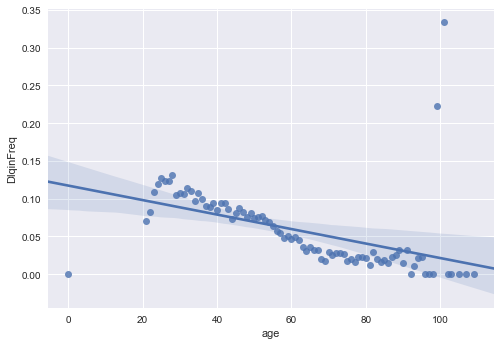

In [5]:
grouped_df = train_df.groupby('age')
dlinq_age = grouped_df['SeriousDlqin2yrs'].aggregate([np.mean,'count']).reset_index()
print(dlinq_age)
dlinq_age.columns =['age','DlqinFreq','count']
sns.regplot(x='age',y='DlqinFreq',data=dlinq_age)
plt.show()


Remove outlier in age

In [5]:
print(train_df.shape)
ind = train_df.age.values != 0 
train_df = train_df.iloc[ind,]
ind = train_df.age.values != 99
train_df = train_df.iloc[ind,]
ind = train_df.age.values != 101
train_df = train_df.iloc[ind,]
print(train_df.shape)

(150000, 17)
(149987, 17)


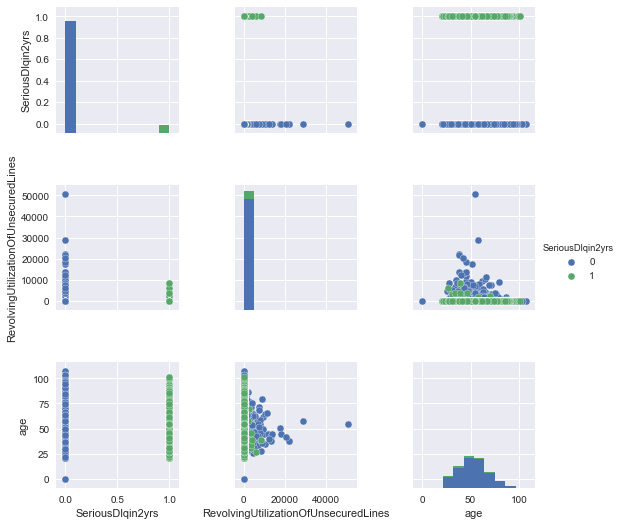

In [72]:
sns.pairplot(train_df[['SeriousDlqin2yrs','RevolvingUtilizationOfUnsecuredLines','age']],hue='SeriousDlqin2yrs')
plt.show()

Feature RevolvingUtilizationOfUnsecuredLines seems have unusual high value. We need to examine
its distribution in training set and test set

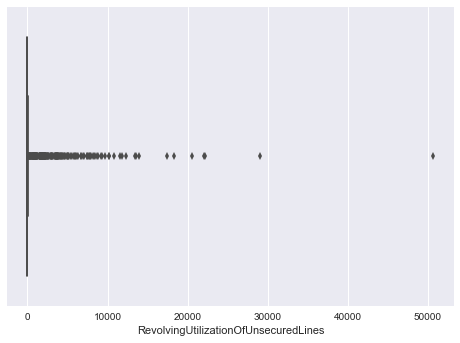

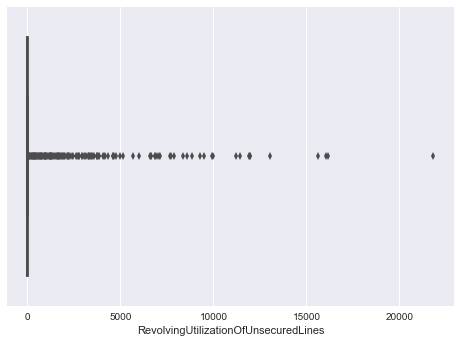

d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


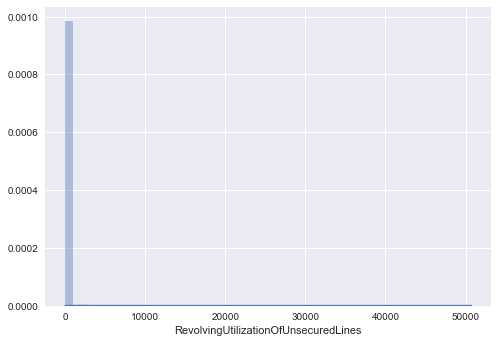

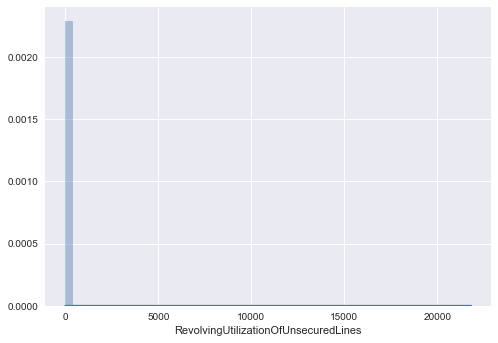

In [20]:
sns.boxplot(train_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()
sns.boxplot(test_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()
sns.distplot(train_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()
sns.distplot(test_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()

U_g1
0    146666
1      3321
Name: ID, dtype: int64
(3321, 18)


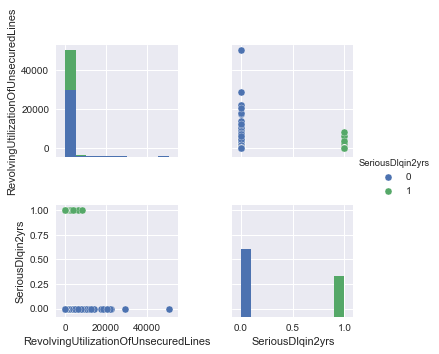

In [43]:
'''
train_df['U_g1'] = train_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: 0 if x<=1 else 1)
grouped_df = train_df.groupby('U_g1')
print (grouped_df['ID'].aggregate('count'))
ind = train_df.U_g1.values == 1
train_df2 = train_df[ind]
print (train_df2.shape)
sns.pairplot(train_df2[['RevolvingUtilizationOfUnsecuredLines','SeriousDlqin2yrs']],hue='SeriousDlqin2yrs')
plt.show()
'''

As 1(100%) is a critical point for utilization by common sense, I firstly split utilization
into 2 groups: Utilization below 1 and above 1. Then based on the graph on top right, 10,000 looks
like another critical point. So I further split "above 1" group into two groups. Overall, there are 
3 groups in RevolvingUtilizationOfUnsecuredLines [0,1),[1,10000),[10000,+]

In [44]:
'''
bins = [-0.001,1,10000,100000]
group_names = [0,1,2]
train_df['U_Category'] = pd.cut(train_df['RevolvingUtilizationOfUnsecuredLines'],bins,labels=group_names)
train_df['U_Category'] = train_df['U_Category'].astype(np.int)
print (train_df['U_Category'].head())
print (set(train_df['U_Category'].values))
print (train_df['U_Category'].dtype)
'''

0    0
1    0
2    0
3    0
4    0
Name: U_Category, dtype: int32
{0, 1, 2}
int32


Distribution of RevolvingUtilizationOfUnsecuredLines is very unbalanced. In addition, for people with
Utilization greater than 10,000, none of them are in default. I will try 3 ways to deal with the outliers
to see how they affect the model performance in cross validation:
    1. simply remove all observations with utilization greater than 10,000
    2. set all utilization greater than 10,000 equals to 10,000
    3. take log10(x+1) transformation

Set all observations with utilization greater than 10,000 equals to 10,000


d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


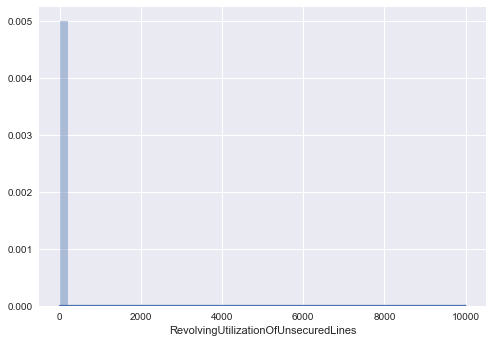

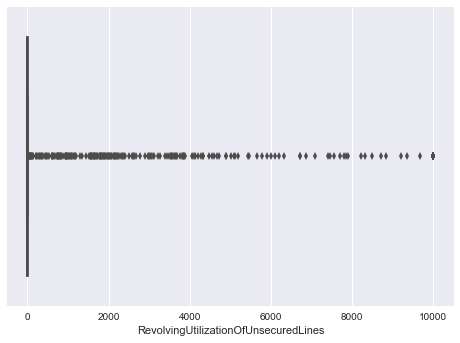

In [61]:
'''
ind = train_df.RevolvingUtilizationOfUnsecuredLines >= 10000
train_df.reset_index()
train_df.loc[ind,'RevolvingUtilizationOfUnsecuredLines'] = 10000
#train_df[ind].RevolvingUtilizationOfUnsecuredLines
#train_df.reset_index()
#train_df.loc[ind,'RevolvingUtilizationOfUnsecuredLines'] == 10000
#print (train_df.shape)
sns.distplot(train_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()
sns.boxplot(train_df['RevolvingUtilizationOfUnsecuredLines'])
plt.show()
'''

Remove all observations with utilization higher than 10,000

(146052, 17)


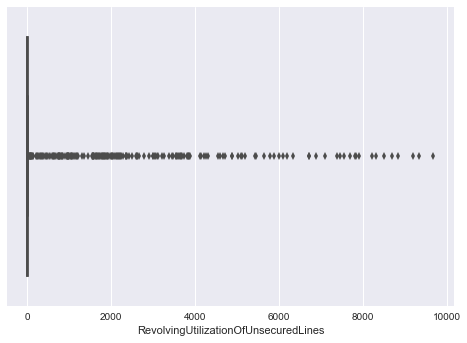

d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


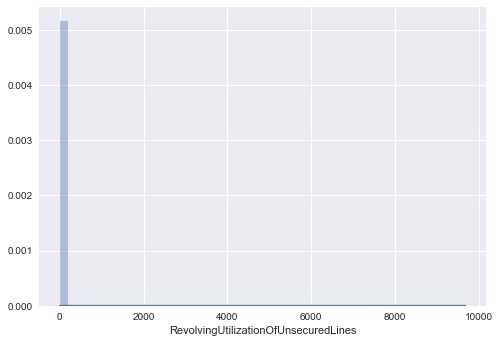

In [64]:
'''
ind = train_df['RevolvingUtilizationOfUnsecuredLines'].values < 10000
train_df = train_df.loc[ind,]
print(train_df.shape)
sns.boxplot(train_df.RevolvingUtilizationOfUnsecuredLines)
plt.show()
sns.distplot(train_df.RevolvingUtilizationOfUnsecuredLines)
plt.show()
'''

Taking log10(x+1) transformation to see if distribution more balanced

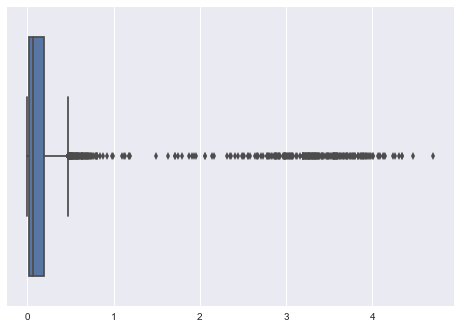

d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


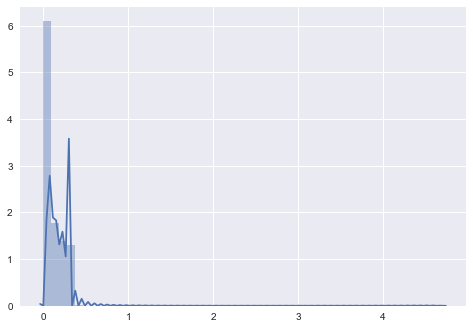

In [6]:
RT = train_df['RevolvingUtilizationOfUnsecuredLines'].values
logRT = np.log10(RT+1)
sns.boxplot(logRT)
plt.show()
sns.distplot(logRT)
plt.show()
train_df['logRT']=logRT
test_df['logRT'] = np.log10(test_df['RevolvingUtilizationOfUnsecuredLines'].values+1)
#logRT = np.log()

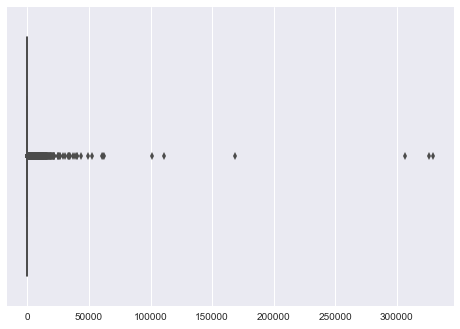

d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


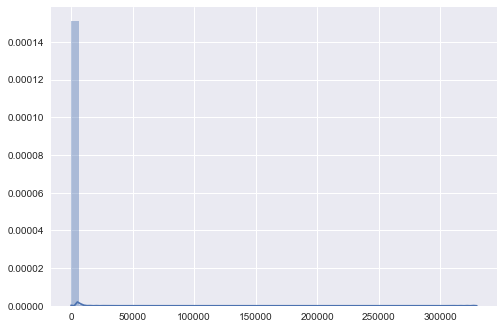

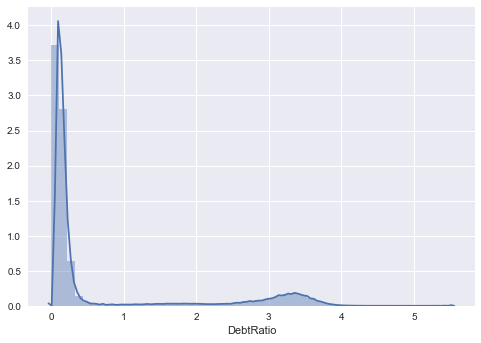

In [7]:
# distribution of debt ratio
sns.boxplot(train_df.DebtRatio.values)
plt.show()
sns.distplot(train_df.DebtRatio.values)
plt.show()
LD = np.log10(train_df.DebtRatio + 1)
sns.distplot(LD)
plt.show()
train_df['logDR'] = LD
test_df['logDR'] = np.log10(test_df['DebtRatio'].values+1)

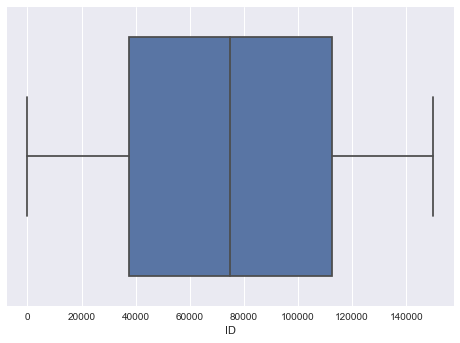

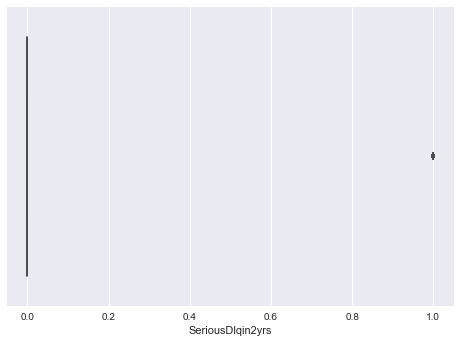

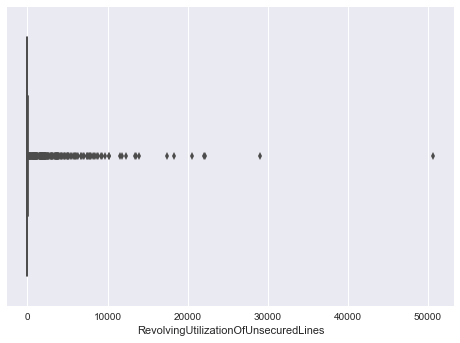

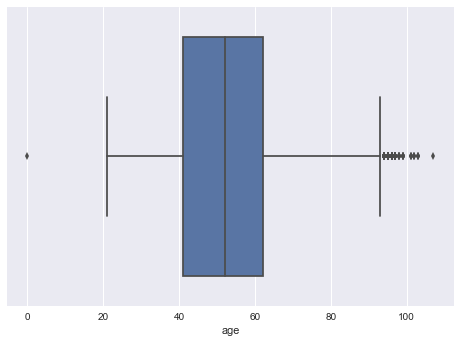

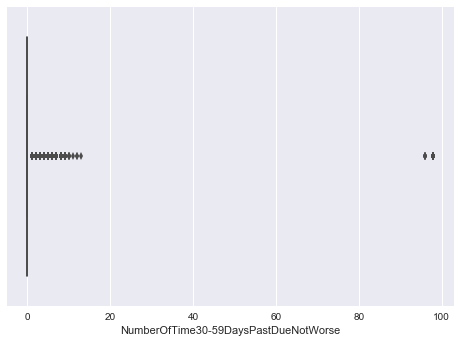

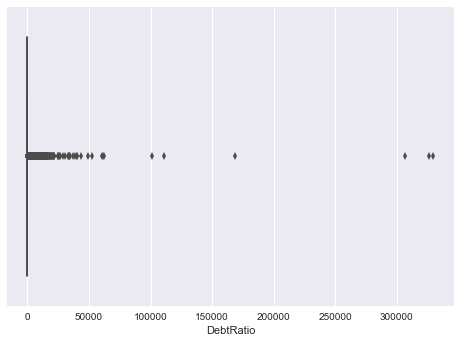

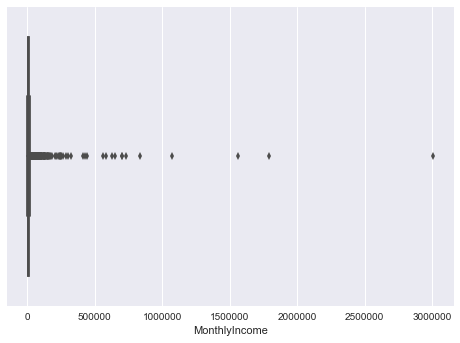

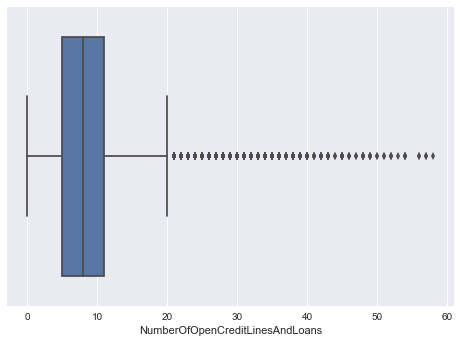

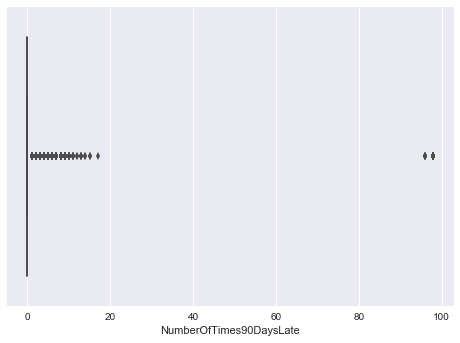

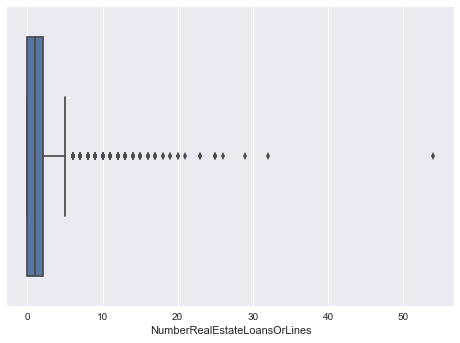

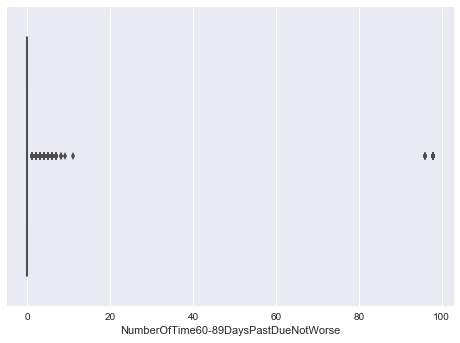

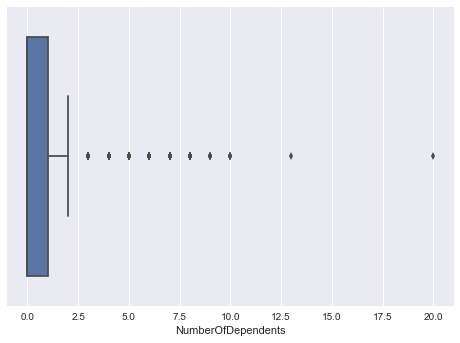

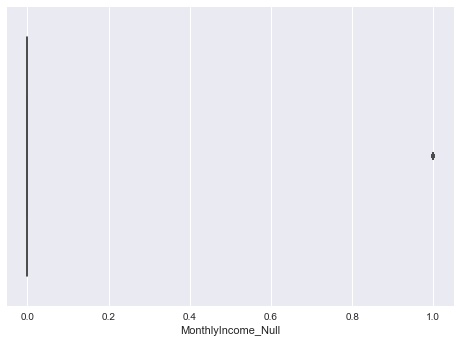

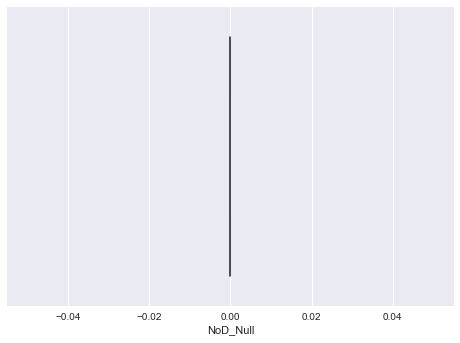

In [64]:
for col in train_df:
    sns.boxplot(train_df[col])
    plt.show()
    

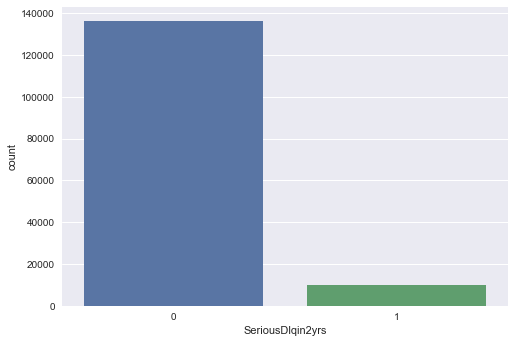

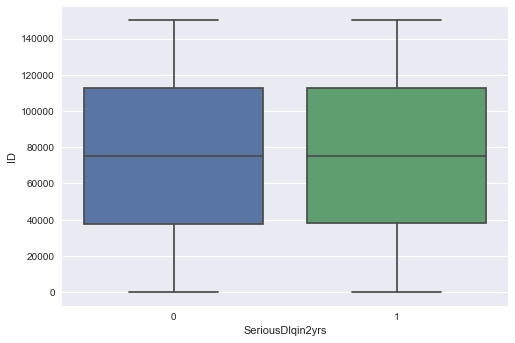

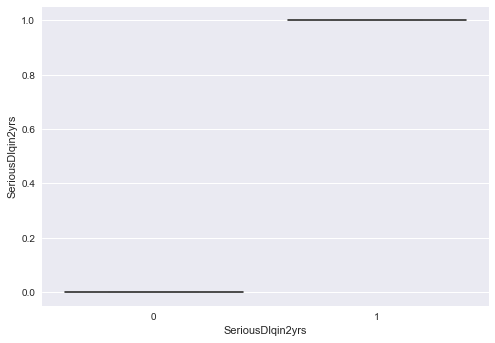

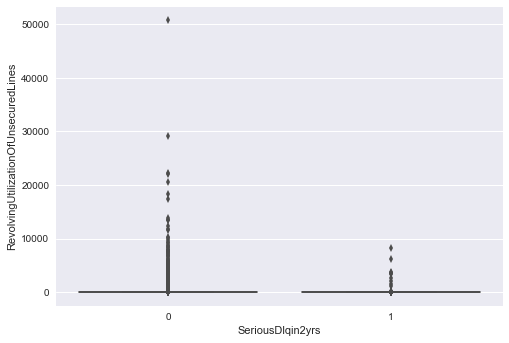

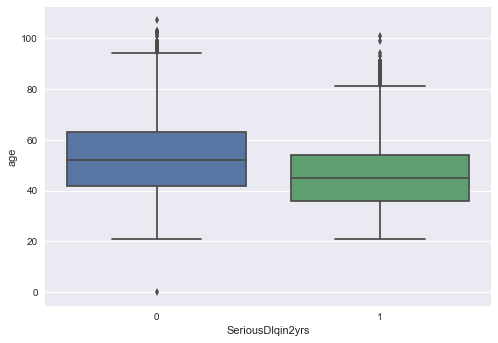

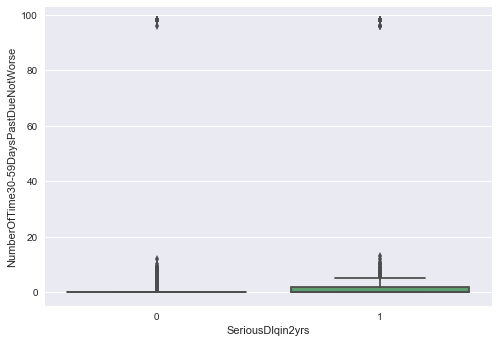

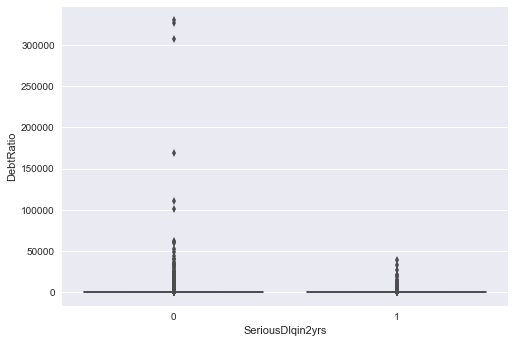

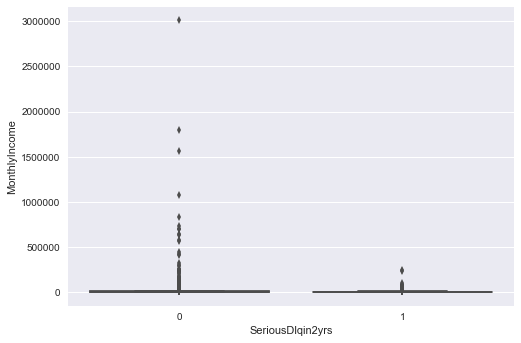

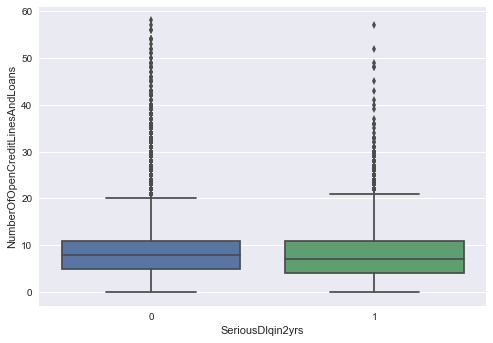

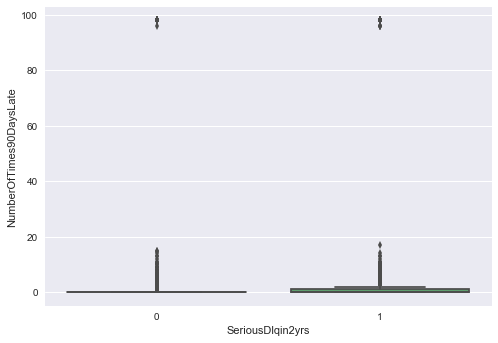

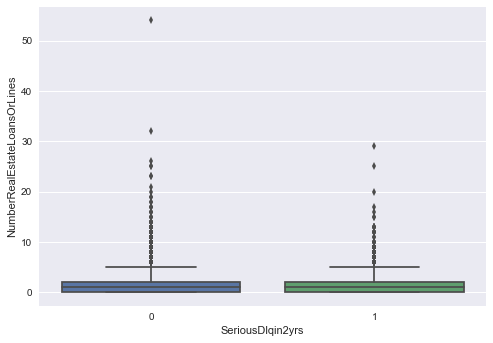

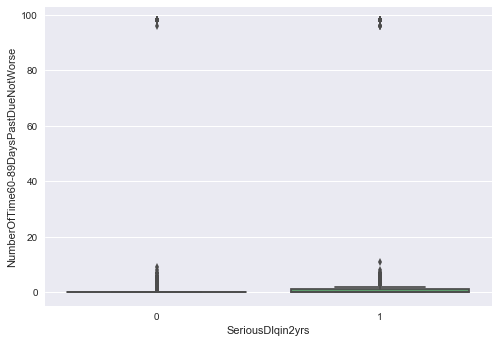

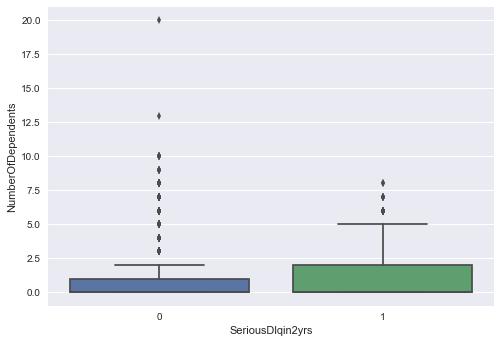

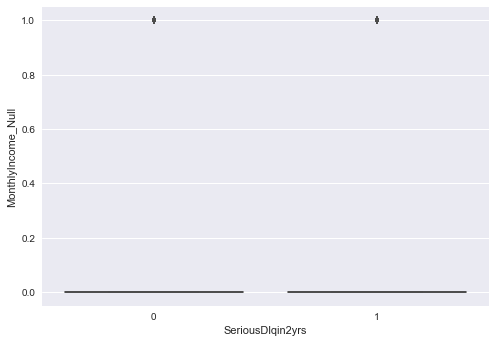

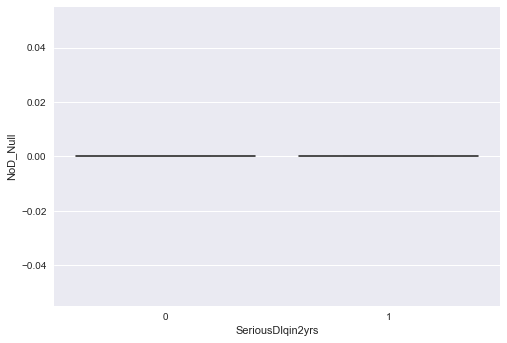

In [65]:
sns.countplot(train_df['SeriousDlqin2yrs'])
plt.show()
for col in train_df:
    sns.boxplot(x='SeriousDlqin2yrs',y=col,data=train_df)
    plt.show()

Split training data into 5 fold. Run xgboost with the original features and plot feature importance

In [11]:
train_y = train_df['SeriousDlqin2yrs']
#'RevolvingUtilizationOfUnsecuredLines'
train_X = train_df.drop(['SeriousDlqin2yrs','ID','RevolvingUtilizationOfUnsecuredLines','DebtRatio'],axis=1,inplace=False)
test_X = test_df.drop(['SeriousDlqin2yrs','ID','RevolvingUtilizationOfUnsecuredLines','DebtRatio'],axis=1,inplace=False)
print(type(train_y))
skf = model_selection.StratifiedKFold(n_splits=5,random_state=100)
xgb_params = {
'eta':0.03,
'max_depth':4,
'sub_sample':0.9,
'colsample_bytree':0.5,
'objective':'binary:logistic',
'eval_metric':'auc',
'silent':0
}

print(train_X.shape)
print(train_X.columns)
print(test_X.shape)

<class 'pandas.core.series.Series'>
(146076, 15)
Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'IncomePerPerson', 'NumOfPastDue', 'MonthlyDebt',
       'NumOfOpenCreditLines', 'MonthlyBalance', 'logRT', 'logDR'],
      dtype='object')
(101503, 15)


In [12]:
best_iteration =[]
best_score= []
training_score = []
for train_ind,val_ind in skf.split(train_X,train_y):
    #print (set(train_y))
    #print (type(train_y))
    X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,]
    y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind]
    #print (set(train_y))
    #print (max(train_ind),min(train_ind),max(val_ind),min(val_ind))
    #print (train_ind,val_ind)
    #print(set(y_train))
    dtrain = xgb.DMatrix(X_train,y_train,feature_names = X_train.columns)
    dval = xgb.DMatrix(X_val,y_val,feature_names = X_val.columns)
    model = xgb.train(xgb_params,dtrain,num_boost_round=1000,
                      evals=[(dtrain,'train'),(dval,'val')],verbose_eval=True,early_stopping_rounds=30)
    best_iteration.append(model.attributes()['best_iteration'])
    best_score.append(model.attributes()['best_score'])
    # training_score.append(model.attributes()['best_msg'].split()[1][-8:])
    #xgb.plot_importance(model)
    plt.show()

[0]	train-auc:0.783602	val-auc:0.781549
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.842567	val-auc:0.836477
[2]	train-auc:0.845897	val-auc:0.838895
[3]	train-auc:0.850196	val-auc:0.842941
[4]	train-auc:0.854028	val-auc:0.846594
[5]	train-auc:0.854066	val-auc:0.846922
[6]	train-auc:0.854003	val-auc:0.846821
[7]	train-auc:0.855737	val-auc:0.849399
[8]	train-auc:0.856586	val-auc:0.849803
[9]	train-auc:0.858088	val-auc:0.850396
[10]	train-auc:0.858432	val-auc:0.850521
[11]	train-auc:0.85843	val-auc:0.850488
[12]	train-auc:0.859451	val-auc:0.852027
[13]	train-auc:0.858889	val-auc:0.851454
[14]	train-auc:0.858355	val-auc:0.851034
[15]	train-auc:0.858097	val-auc:0.850732
[16]	train-auc:0.858259	val-auc:0.850892
[17]	train-auc:0.858178	val-auc:0.851049
[18]	train-auc:0.85824	val-auc:0.851077
[19]	train-auc:0.857948	val-auc:0.851166
[20]	train-auc:0.857718	val-auc:0.850806
[21]	train-a

In [15]:
model.attributes()['best_msg'].split()[1][10:]

'0.890094'

In [13]:
print (best_iteration)
print (best_score)
print (training_score)
print (np.asarray(best_score).astype(np.float).mean())
print (np.asarray(training_score).astype(np.float).mean())

['451', '392', '380', '551', '402']
['0.862198', '0.862452', '0.864647', '0.866023', '0.871598']
[]
0.8653836
nan


d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Define a function to perform cross validation in order to tune key parameters: 'eta','max_depth','sub_sample','colsample_bytree'

In [16]:
def xgbCV(eta=[0.05],max_depth=[6],sub_sample=[0.9],colsample_bytree=[0.9]):
    train_y = train_df['SeriousDlqin2yrs']
    #'RevolvingUtilizationOfUnsecuredLines'
    train_X = train_df.drop(['SeriousDlqin2yrs','ID','RevolvingUtilizationOfUnsecuredLines','DebtRatio'],axis=1,inplace=False)
    test_X = test_df.drop(['SeriousDlqin2yrs','ID','RevolvingUtilizationOfUnsecuredLines','DebtRatio'],axis=1,inplace=False)
    print(type(train_y))
    skf = model_selection.StratifiedKFold(n_splits=5,random_state=100)
    
    
    train_performance ={}
    val_performance={}
    for each_param in itertools.product(eta,max_depth,sub_sample,colsample_bytree):
        xgb_params = {
                    'eta':each_param[0],
                    'max_depth':each_param[1],
                    'sub_sample':each_param[2],
                    'colsample_bytree':each_param[3],
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }
        best_iteration =[]
        best_score=[]
        training_score=[]
        for train_ind,val_ind in skf.split(train_X,train_y):
        #print (set(train_y))
        #print (type(train_y))
            X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,]
            y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind]
            #print (set(train_y))
            #print (max(train_ind),min(train_ind),max(val_ind),min(val_ind))
            #print (train_ind,val_ind)
            #print(set(y_train))
            dtrain = xgb.DMatrix(X_train,y_train,feature_names = X_train.columns)
            dval = xgb.DMatrix(X_val,y_val,feature_names = X_val.columns)
            model = xgb.train(xgb_params,dtrain,num_boost_round=1000,
                              evals=[(dtrain,'train'),(dval,'val')],verbose_eval=True,early_stopping_rounds=30)
            best_iteration.append(model.attributes()['best_iteration'])
            best_score.append(model.attributes()['best_score'])
            training_score.append(model.attributes()['best_msg'].split()[1][10:])
        val_performance[each_param] = (np.asarray(best_score).astype(np.float).mean())
        train_performance[each_param] = (np.asarray(training_score).astype(np.float).mean())
    return (train_performance,val_performance)
        #xgb.plot_importance(model)
        #plt.show()
xgbCV(eta=[0.03,0.05,0.07],max_depth=[4,6,8,10],colsample_bytree=[0.5,0.7,0.9]) 


<class 'pandas.core.series.Series'>
[0]	train-auc:0.784044	val-auc:0.784596
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[1]	train-auc:0.843708	val-auc:0.838979
[2]	train-auc:0.846775	val-auc:0.841261
[3]	train-auc:0.848862	val-auc:0.84355
[4]	train-auc:0.853351	val-auc:0.848519
[5]	train-auc:0.853422	val-auc:0.84883
[6]	train-auc:0.853476	val-auc:0.848876
[7]	train-auc:0.855771	val-auc:0.851717
[8]	train-auc:0.856692	val-auc:0.852184
[9]	train-auc:0.85838	val-auc:0.852868
[10]	train-auc:0.858626	val-auc:0.853026
[11]	train-auc:0.858785	val-auc:0.853131
[12]	train-auc:0.859836	val-auc:0.854376
[13]	train-auc:0.859364	val-auc:0.853943
[14]	train-auc:0.858798	val-auc:0.853386
[15]	train-auc:0.858578	val-auc:0.85304
[16]	train-auc:0.858758	val-auc:0.853262
[17]	train-auc:0.858718	val-auc:0.853476
[18]	train-auc:0.858767	val-auc:0.853473
[19]	train-auc:0.85861	val-auc:0.853544
[20]	train-auc:0.858

({(0.03, 4, 0.9, 0.5): 0.8781274,
  (0.03, 4, 0.9, 0.7): 0.87434020000000001,
  (0.03, 4, 0.9, 0.9): 0.87780179999999997,
  (0.03, 6, 0.9, 0.5): 0.88914779999999993,
  (0.03, 6, 0.9, 0.7): 0.89028760000000007,
  (0.03, 6, 0.9, 0.9): 0.89126060000000007,
  (0.03, 8, 0.9, 0.5): 0.90059320000000009,
  (0.03, 8, 0.9, 0.7): 0.90416639999999993,
  (0.03, 8, 0.9, 0.9): 0.90315119999999993,
  (0.03, 10, 0.9, 0.5): 0.9224658,
  (0.03, 10, 0.9, 0.7): 0.9128094000000001,
  (0.03, 10, 0.9, 0.9): 0.91210799999999992,
  (0.05, 4, 0.9, 0.5): 0.8786210000000001,
  (0.05, 4, 0.9, 0.7): 0.87939880000000004,
  (0.05, 4, 0.9, 0.9): 0.88029880000000005,
  (0.05, 6, 0.9, 0.5): 0.89008240000000005,
  (0.05, 6, 0.9, 0.7): 0.89163879999999995,
  (0.05, 6, 0.9, 0.9): 0.89116420000000007,
  (0.05, 8, 0.9, 0.5): 0.90463859999999996,
  (0.05, 8, 0.9, 0.7): 0.90016619999999992,
  (0.05, 8, 0.9, 0.9): 0.90174739999999998,
  (0.05, 10, 0.9, 0.5): 0.92644900000000008,
  (0.05, 10, 0.9, 0.7): 0.91074820000000012,
  (0.

In [14]:
train = xgb.DMatrix(train_X,train_y,feature_names=train_X.columns)
test = xgb.DMatrix(test_X,feature_names=test_X.columns)
xgb_params = {
                    'eta':0.03,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model = xgb.train(xgb_params,train,num_boost_round=500)
ypred = final_model.predict(test)


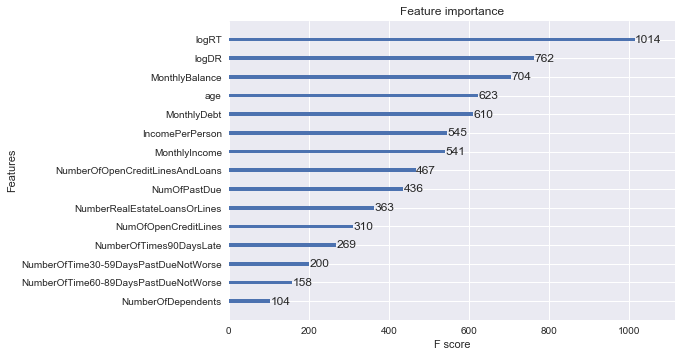

In [15]:
xgb.plot_importance(final_model)
plt.show()

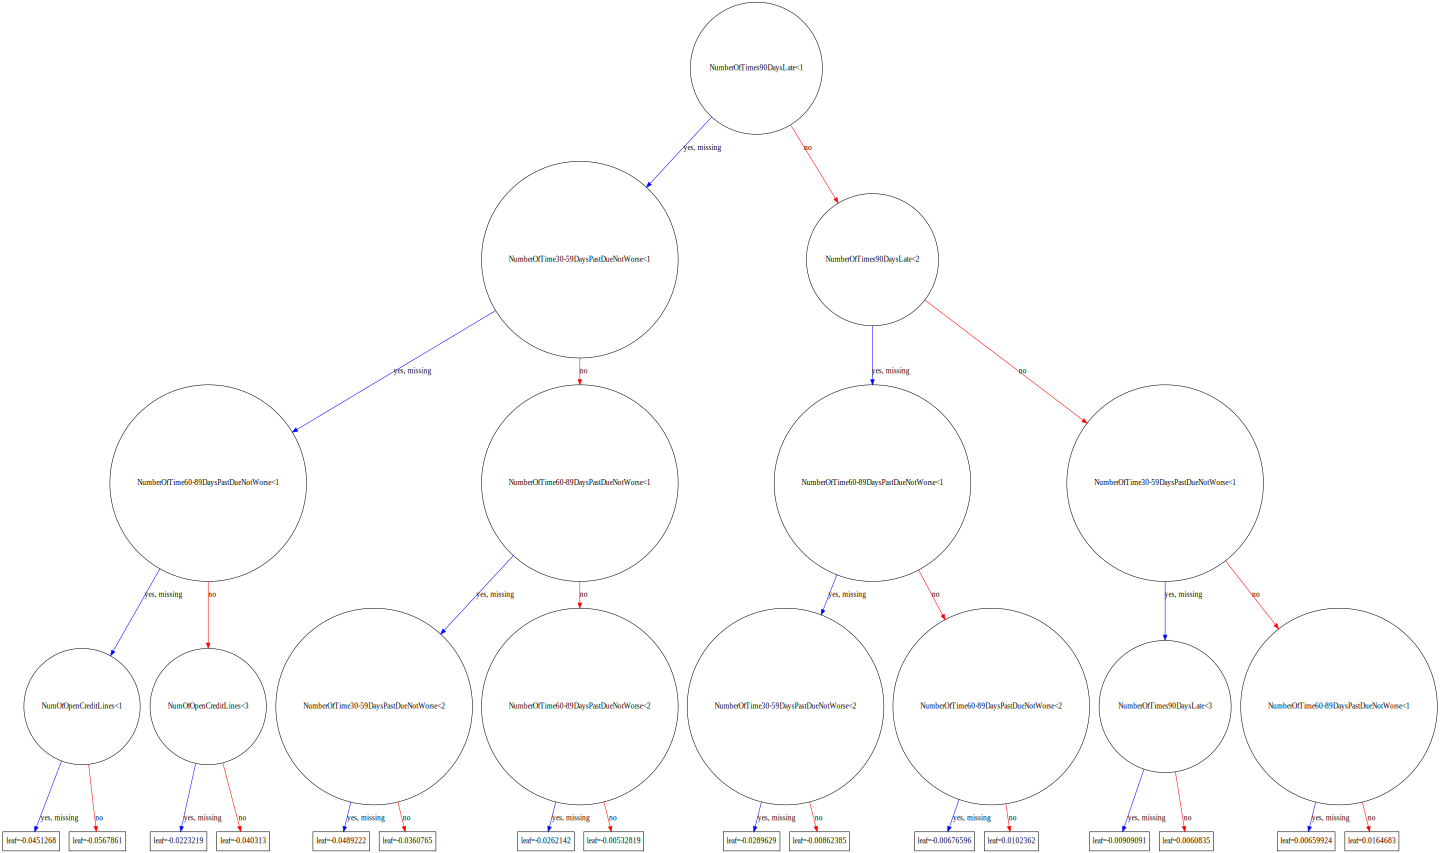

In [20]:

xgb.to_graphviz(final_model,num_trees=0,size='20,20')
#plt.show()

In [16]:
yout = pd.DataFrame({'Id':test_df.ID.values,'Probability':ypred})
yout.to_csv('E:\\Kaggle\\Give Me Some Credit\\result\\xgboost.csv',index=False)